In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ast

# Load dataset and drop unwanted companies
df = pd.read_csv("../data/data_science_job_posts_2025.csv")
df = df[~df["company"].isin(["company_967", "company_209"])].copy()

# Extract max salary from text (e.g., "€100,472 - €200,938" -> 200938.0)
def extract_salary_max(s):
    if pd.isna(s):
        return np.nan
    nums = re.findall(r"[\d,]+", str(s))
    if not nums:
        return np.nan
    return float(nums[-1].replace(",", ""))

df["salary_max"] = df["salary"].apply(extract_salary_max)
n_unparsed_salary = df["salary_max"].isna().sum()
print(f"Unparsed / NaN salary_max rows: {n_unparsed_salary}")

# Keep only salary_max, drop other salary-related columns
salary_cols_to_drop = [
    c for c in df.columns
    if c.startswith("salary") and c not in ["salary_max"]
]
df = df.drop(columns=salary_cols_to_drop)


Unparsed / NaN salary_max rows: 0


In [10]:
# Parse company_size into a numeric value (employees or revenue)
def parse_company_size_num(x):
    if pd.isna(x):
        return np.nan

    s = str(x).strip()
    if s == "":
        return np.nan

    s_up = s.replace("€", "").upper()

    # Revenue formats: e.g. "352.44B", "45M"
    m = re.match(r"^\s*([\d,\.]+)\s*([BM])\s*$", s_up)
    if m:
        num = float(m.group(1).replace(",", ""))
        unit = m.group(2)
        if unit == "B":
            return num * 1_000_000_000
        else:
            return num * 1_000_000

    # Employee counts like "155,030" -> keep only digits and dot
    s_clean = re.sub(r"[^\d\.]", "", s_up)
    if s_clean == "":
        return np.nan

    # If still not a numeric pattern, treat as NaN
    if not re.match(r"^\d+(\.\d+)?$", s_clean):
        return np.nan

    return float(s_clean)

# Map original company_size + numeric value into small / medium / large
def company_size_group(original, numeric):
    if pd.isna(original) or pd.isna(numeric):
        return np.nan

    s = str(original).upper()

    if "B" in s or "M" in s:
        return "large"

    if numeric < 1000:
        return "small"
    elif numeric < 20000:
        return "medium"
    else:
        return "large"

df["company_size_num"] = df["company_size"].apply(parse_company_size_num)
df["company_size_group"] = df.apply(
    lambda row: company_size_group(row["company_size"], row["company_size_num"]),
    axis=1,
)

n_unparsed_company = df["company_size_num"].isna().sum()
n_unparsed_group = df["company_size_group"].isna().sum()
print(f"Unparsed / NaN company_size_num rows: {n_unparsed_company}")
print(f"NaN company_size_group rows: {n_unparsed_group}")

df = df.dropna(subset=["company_size_group"])

print("\nSample company size parsing:")
print(
    df[["company", "company_size", "company_size_num", "company_size_group"]]
    .head()
)


Unparsed / NaN company_size_num rows: 15
NaN company_size_group rows: 15

Sample company size parsing:
       company company_size  company_size_num company_size_group
0  company_003     €352.44B      3.524400e+11              large
1  company_005      155,030      1.550300e+05              large
2  company_007       25,930      2.593000e+04              large
3  company_008       34,690      3.469000e+04              large
4  company_009        1,800      1.800000e+03             medium


In [11]:
# Clean skills into a pipe-separated string and compute skill_count
def clean_skills(s):
    if pd.isna(s):
        return ""

    text = str(s)
    skills_raw = None
    stripped = text.strip()

    if stripped.startswith("[") and stripped.endswith("]"):
        parsed = ast.literal_eval(stripped)
        if isinstance(parsed, (list, tuple, set)):
            skills_raw = list(parsed)

    if skills_raw is None:
        skills_raw = re.split(r"[,\|]", text)

    cleaned = []
    for sk in skills_raw:
        sk_str = str(sk).strip().strip("'\"").lower()
        if sk_str:
            cleaned.append(sk_str)

    seen = set()
    unique = []
    for sk in cleaned:
        if sk not in seen:
            seen.add(sk)
            unique.append(sk)

    return "|".join(unique)

df["skills_clean"] = df["skills"].apply(clean_skills)
df["skill_count"] = df["skills_clean"].apply(
    lambda s: 0 if s == "" else s.count("|") + 1
)

# Adjust salary_max based on company_size_group
def adjust_salary_max(row):
    base = row["salary_max"]
    group = row["company_size_group"]

    if pd.isna(base):
        return np.nan

    if group == "large":
        return base * 1.30
    elif group == "medium":
        return base * 1.10
    else:
        return base

df["salary_max_new"] = df.apply(adjust_salary_max, axis=1)



Job count per company size group:
  company_size_group  job_count
0              large        481
1             medium        239
2              small        205


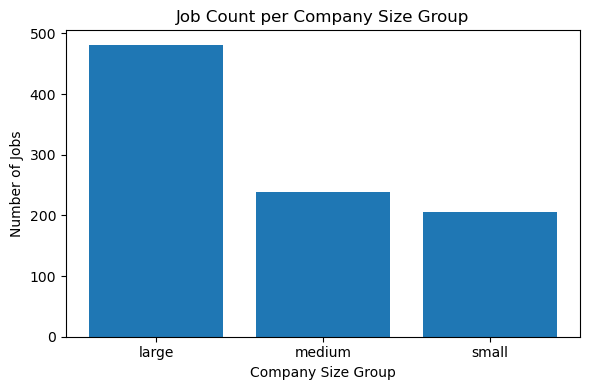


Average salary per company size group:
  company_size_group  salary_max_new
0              large   181330.162162
1             medium   159717.753975
2              small   158667.356098


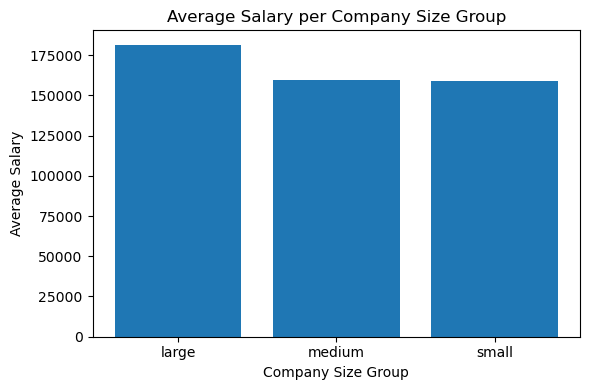


Average skill count per job per company size group:
  company_size_group  skill_count
0              large     5.496881
1             medium     4.012552
2              small     2.434146


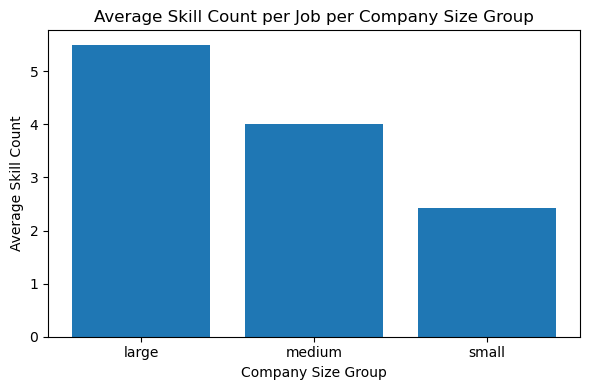

In [12]:
df_grouped = df.dropna(subset=["company_size_group"]).copy()

# Job count per company_size_group
job_counts = (
    df_grouped["company_size_group"]
    .value_counts()
    .sort_index()
    .reset_index()
)
job_counts.columns = ["company_size_group", "job_count"]

print("\nJob count per company size group:")
print(job_counts)

plt.figure(figsize=(6, 4))
plt.bar(job_counts["company_size_group"], job_counts["job_count"])
plt.title("Job Count per Company Size Group")
plt.xlabel("Company Size Group")
plt.ylabel("Number of Jobs")
plt.tight_layout()
plt.show()

# Average adjusted salary per company_size_group
salary_stats = (
    df_grouped.groupby("company_size_group")["salary_max_new"]
    .mean()
    .reset_index()
    .sort_values("company_size_group")
)

print("\nAverage salary per company size group:")
print(salary_stats)

plt.figure(figsize=(6, 4))
plt.bar(salary_stats["company_size_group"], salary_stats["salary_max_new"])
plt.title("Average Salary per Company Size Group")
plt.xlabel("Company Size Group")
plt.ylabel("Average Salary")
plt.tight_layout()
plt.show()

# Average skill_count per job per company_size_group
skill_stats = (
    df_grouped.groupby("company_size_group")["skill_count"]
    .mean()
    .reset_index()
    .sort_values("company_size_group")
)

print("\nAverage skill count per job per company size group:")
print(skill_stats)

plt.figure(figsize=(6, 4))
plt.bar(skill_stats["company_size_group"], skill_stats["skill_count"])
plt.title("Average Skill Count per Job per Company Size Group")
plt.xlabel("Company Size Group")
plt.ylabel("Average Skill Count")
plt.tight_layout()
plt.show()


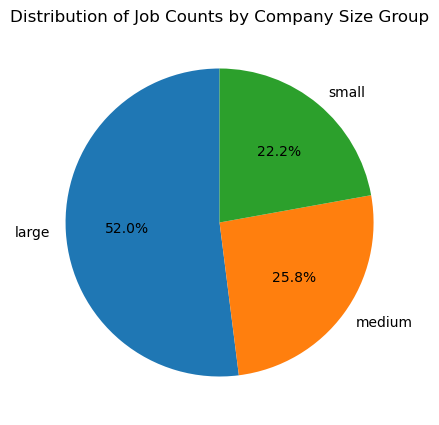

/var/folders/0t/nvsb9hb16cz3yyv_k6byz7yr0000gn/T/ipykernel_57399/4209806951.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


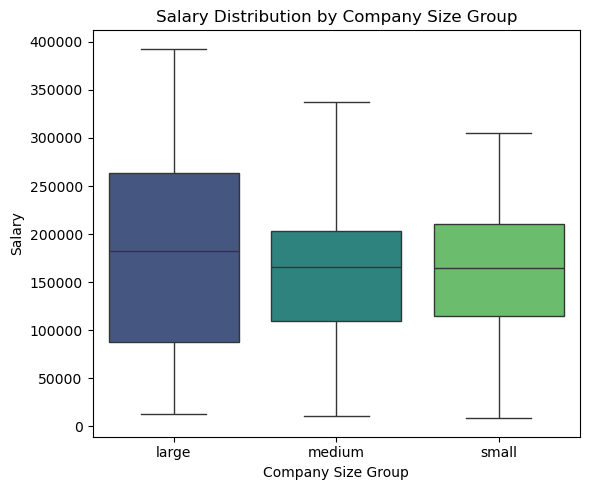

/var/folders/0t/nvsb9hb16cz3yyv_k6byz7yr0000gn/T/ipykernel_57399/4209806951.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


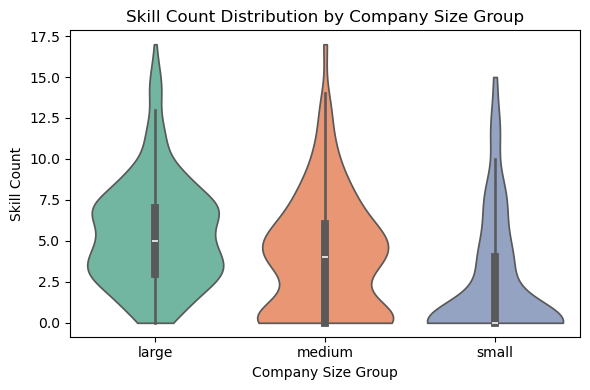

In [13]:
# Pie chart of job distribution by company size group
df_grouped["company_size_group"].value_counts().plot(
    kind="pie", autopct="%1.1f%%", figsize=(6, 5), startangle=90
)
plt.ylabel("")
plt.title("Distribution of Job Counts by Company Size Group")
plt.show()

# Boxplot of salary distribution by company size group
plt.figure(figsize=(6, 5))
sns.boxplot(
    data=df_grouped,
    x="company_size_group",
    y="salary_max_new",
    palette="viridis"
)
plt.title("Salary Distribution by Company Size Group")
plt.xlabel("Company Size Group")
plt.ylabel("Salary")
plt.tight_layout()
plt.show()

# Violin plot of skill count distribution by company size group
plt.figure(figsize=(6, 4))
sns.violinplot(
    data=df_grouped,
    x="company_size_group",
    y="skill_count",
    palette="Set2",
    cut=0
)
plt.title("Skill Count Distribution by Company Size Group")
plt.xlabel("Company Size Group")
plt.ylabel("Skill Count")
plt.tight_layout()
plt.show()

# Save cleaned dataset
df.to_csv("../data/data_science_job_posts_2025_clean2.csv", index=False)



=== Mainstream skill share by company_size_group ===
company_size_group  large  medium  small
skill                                   
aws                 0.285   0.192  0.156
azure               0.216   0.105  0.117
python              0.819   0.640  0.366
sql                 0.576   0.448  0.220


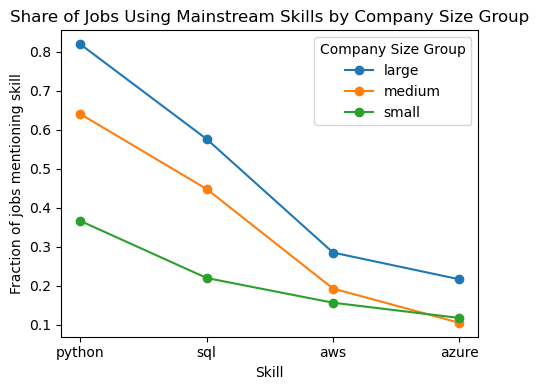

In [18]:
mainstream_skills = ["python", "sql", "aws", "azure"]

stats = []
valid_df = df[df["company_size_group"].notna()].copy()

for g in sorted(valid_df["company_size_group"].unique()):
    subset = valid_df[valid_df["company_size_group"] == g]
    total = len(subset)
    if total == 0:
        continue

    for sk in mainstream_skills:
        count = subset["skills_clean"].apply(
            lambda s, sk=sk: sk in str(s).split("|")
        ).sum()
        share = count / total
        stats.append({
            "company_size_group": g,
            "skill": sk,
            "share": share,
        })

skill_stats = pd.DataFrame(stats)

print("\n=== Mainstream skill share by company_size_group ===")
print(
    skill_stats
        .pivot(index="skill", columns="company_size_group", values="share")
        .round(3)
)

# Optional: simple bar plot for visual comparison
plt.figure(figsize=(5, 4))
for i, g in enumerate(sorted(valid_df["company_size_group"].unique())):
    subset = skill_stats[skill_stats["company_size_group"] == g]
    plt.plot(
        subset["skill"],
        subset["share"],
        marker="o",
        label=g,
    )

plt.title("Share of Jobs Using Mainstream Skills by Company Size Group")
plt.xlabel("Skill")
plt.ylabel("Fraction of jobs mentioning skill")
plt.legend(title="Company Size Group")
plt.tight_layout()
plt.show()
